#CafChem Teaching - Basic MLP.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/MauricioCafiero/CafChemTeach/blob/main/notebooks/BasicMLP_CafChem.ipynb)

## This notebook allows you to:
- Featurize molecules based on SMILES strings.
- Use a multi-layer perceptron model to fit a common solubility dataset.

## Requirements:
- If using on Colab, it will install all needed libraries.
- Can use your local environment or a CPU runtime on Colab.

## Setup
- Installing rdkit only needed if using Colab.

In [1]:
!pip install rdkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.3/36.3 MB 40.6 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import time
from rdkit import Chem
from rdkit.Chem import AllChem, Draw, Descriptors
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import TensorDataset, DataLoader

## Functions
The functions below allow you to:
- Featurize a list of molecules.
- Check the features for NaN and remove those entries.
- Create Torch datasets and dataloaders
- Create the MLP model
- Train the model
- Predict solubility of a new molecule using the molecule

In [3]:
def rdkit_featurize(smiles_list: list,target_list: list, print_flag: bool):
  '''
    Takes a list of SMILES strings and creates features using the RDKit set of
    descriptors.

      Args:
        smiles_list: List of SMILES to featurize
        target_list: list of the ground trutch values for each molecule
        print_flag: True: print the number of descriptors for each molecule
                    False: do not print anything
      Returns:
        X: 2D list of features (rows are molecules, columns are features)
        y: list of target values
        mols: list of RDKit mol objects
        legend: list of SMILES strings (should be identical to input list,
                unless a molecule could not be featurized, in which case that molecule
                is left out)
  '''
  X = []
  mols = []
  legend = []
  y = []
  for i,smile in enumerate(smiles_list):
    try:
      mol = Chem.MolFromSmiles(smile)
      dictionary_descriptors = Chem.Descriptors.CalcMolDescriptors(mol)
      temp_vec = []
      for key in dictionary_descriptors:
        temp_vec.append(dictionary_descriptors[key])
      X.append(temp_vec)
      mols.append(mol)
      legend.append(smile)
      y.append(target_list[i])
      if print_flag:
        print(f"{len(temp_vec)} descriptors calculated for: {smile}")
        print("--------------------------------------------------------")
    except:
      print(f"Could not featurize molecule {i}")

  print(f"Total number of molecules: {len(X)}")
  print(f"Total number of descriptors per molecule: {len(X[0])}")

  return X, y, mols, legend

def check_for_nan(f: list, y: list, Xa: list):
  '''
    Accepts the features array, the targets list, and the SMILES list. Checks
    the feature array for NaN. Removes any rows with NaN from features, targets
    and SMILES.

      Args:
        f: 2D list of features (rows are molecules, columns are features)
        y: list of target values
        Xa: list of SMILES strings
      Returns:
        f: trimmed 2D list of features (rows are molecules, columns are features)
        y: trimmed list of target values
        Xa: trimmed list of SMILES strings
  '''
  f = np.array(f)
  y = np.array(y)
  Xa = np.array(Xa)
  nan_indicies = np.isnan(f)
  bad_rows = []
  for i, row in enumerate(nan_indicies):
      for item in row:
          if item == True:
              if i not in bad_rows:
                  #print(f"Row {i} has a NaN.")
                  bad_rows.append(i)

  print(f"Old dimensions are: {f.shape}.")

  for j,i in enumerate(bad_rows):
      k=i-j
      f = np.delete(f,k,axis=0)
      y = np.delete(y,k,axis=0)
      Xa = np.delete(Xa,k,axis=0)
      #print(f"Deleting row {k} from arrays.")

  print(f"New dimensions are: {f.shape}")

  return f, y, Xa

class MLP_Model(nn.Module):
  '''
  Multilayer Perceptron Model using PyTorch.
    Args:
      neurons: number of neurons in each hidden layer
      input_dims: number of input dimensions
      num_hidden_layers: number of hidden layers
  '''
  def __init__(self, neurons: int, input_dims: int, num_hidden_layers: int):
    super(MLP_Model, self).__init__()
    self.neurons = neurons
    self.input_dims = input_dims
    self.num_hidden_layers = num_hidden_layers
    self.batchnorm = nn.BatchNorm1d(self.input_dims)
    self.linear_input = nn.Sequential(
        nn.Linear(self.input_dims, self.neurons),
        nn.ReLU6())
    self.linear_relu6 = nn.Sequential(
        nn.Linear(self.neurons, self.neurons),
        nn.ReLU6())
    self.linear_output = nn.Linear(self.neurons, 1)

    f = open("MLP_model_params.txt","w")
    f.write(f"neurons: {self.neurons}\n")
    f.write(f"input_dims: {self.input_dims}\n")
    f.write(f"num_hidden_layers: {self.num_hidden_layers}")
    f.close()

  def forward(self, x):
    '''
      Passes the input through a batch normalization layer, an input layer,
      a number of hidden layers, and an output layer.

        Args:
          x: input tensor
        Returns:
          output: output tensor
    '''
    x = self.batchnorm(x)
    x = self.linear_input(x)
    for i in range(self.num_hidden_layers):
      x = self.linear_relu6(x)
    output = self.linear_output(x)
    return output

def train(dataloader, model, loss_fn, optimizer):
  '''
    Trains the model for one epoch.

    Args:
      dataloader: dataloader for the training data
      model: model to train
      loss_fn: loss function to use
      optimizer: optimizer to use
    Returns:
      model: trained model
  '''
  size = len(dataloader.dataset)
  model.train()

  total_loss = 0

  for batch, (X, y) in enumerate(dataloader):
    optimizer.zero_grad()

    pred = model(X)
    loss = loss_fn(pred, y.view(-1,1))
    total_loss += loss

    loss.backward()
    optimizer.step()

    if batch % 2 == 0:
      current = batch * len(X)
      avg_loss = total_loss / (batch + 1)
      print(f"Batch: {batch}, Loss: {avg_loss:.7f} [{current:>5d}/{size:>5d}]")

  return model

def evaluate_training(X_train, y_train, X_test, y_test, model):
  '''
    Evaluates the model on the training and test data.

    Args:
      X_train: training data
      y_train: training truths
      X_test: test data
      y_test: test truths
      model: model to evaluate
    Returns:
      train_r2: R^2 score of the training data
      test_r2: R^2 score of the test data
      Plots the training and test data against the model's predictions.
  '''
  X_train = torch.tensor(X_train, dtype=torch.float32)
  X_test = torch.tensor(X_test, dtype=torch.float32)

  model.eval()
  train_pred = model(X_train)
  test_pred = model(X_test)
  y_total = np.concatenate((y_train, y_test), axis=0)

  train_r2 = r2_score(y_train, train_pred.detach().numpy())
  test_r2 = r2_score(y_test, test_pred.detach().numpy())
  print(f"Train R2 Score: {train_r2}")
  print(f"Test R2 Score: {test_r2}")

  plt.scatter(y_train,train_pred.detach().numpy(),color="blue",label="ML-train")
  plt.scatter(y_test,test_pred.detach().numpy(),color="green",label="ML-valid")
  plt.plot(y_total,y_total,color="red",label="Best Fit")
  plt.legend()
  plt.xlabel("known")
  plt.ylabel("predicted")
  plt.show

  return train_r2, test_r2

def predict_single_value(smiles_to_predict: str, model, scaler = None, truth = None):
  '''
    Predicts the value of a single SMILES string. Featurizes the SMILES, applies
    the scaler if provided, and passes the feature vector through the model.

    Args:
      smiles_to_predict: SMILES string to predict
      model: model to use for prediction
      featurizer: "fingerprints", "rdkit", or "mordred"
      scaler: scaler to use for scaling the feature vector
      truth (optional): truth value to compare the prediction to
    Returns:
      prediction: predicted value
  '''
  print(f"Predicting value for {smiles_to_predict}")
  mol = Chem.MolFromSmiles(smiles_to_predict)
  dictionary_descriptors = Chem.Descriptors.CalcMolDescriptors(mol)
  temp_vec = []
  for key in dictionary_descriptors:
    temp_vec.append(dictionary_descriptors[key])

  if scaler is not None:
    temp_vec = scaler.transform([temp_vec])

  temp_vec = np.array(temp_vec).reshape(1,-1)
  temp_tensor = torch.tensor(temp_vec, dtype=torch.float32)

  model.eval()

  with torch.no_grad():
    prediction = model(temp_tensor).item()

  if truth is not None:
    plot_text = f"Prediction: {prediction}, Truth: {truth}"
  else:
    plot_text = f"Prediction: {prediction}"

  print(plot_text)
  return prediction

def create_data_loader(X_train, y_train, X_test, y_test, batch_size: int, shuffle = True):
  '''
    Creates a data loader for the training and test data.

    Args:
      X_train: training data
      y_train: training truths
      X_test: test data
      y_test: test truths
      batch_size: batch size for the data loader
      shuffle: whether to shuffle the training data
    Returns:
      train_dataset: training dataset
      test_dataset: test dataset
      train_loader: training data loader
      test_loader: test data loader
  '''
  X_train = torch.tensor(X_train, dtype=torch.float32)
  y_train = torch.tensor(y_train, dtype=torch.float32)
  X_test = torch.tensor(X_test, dtype=torch.float32)
  y_test = torch.tensor(y_test, dtype=torch.float32)

  train_dataset = TensorDataset(X_train, y_train)
  test_dataset = TensorDataset(X_test, y_test)

  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle)
  test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

  return train_dataset, test_dataset, train_loader, test_loader

def load_model():
   '''
    Loads a PyTorch model from a text file containing the model parameters
    and a .pt file containing the model weights.

    Args:
      None
    Returns:
      model: The loaded PyTorch model.
   '''
   f = open("MLP_model_params.txt","r")
   lines = f.readlines()
   f.close()

   neurons = lines[0].split()[1]
   input_dims = lines[1].split()[1]
   num_hidden_layers = lines[2].split()[1]

   model = MLP_Model(neurons=int(neurons), input_dims=int(input_dims), num_hidden_layers=int(num_hidden_layers))
   model.load_state_dict(torch.load("saved_model.pt",weights_only=True))

   return model

## Read in data
- Upload the delaney.csv file from the CafChemTeach repository.

In [4]:
df = pd.read_csv('/content/delaney.csv')
df.head()

,Compound ID,measured log(solubility:mol/L),ESOL predicted log(solubility:mol/L),SMILES
0,"1,1,1,2-Tetrachloroethane",-2.18,-2.794,ClCC(Cl)(Cl)Cl
1,"1,1,1-Trichloroethane",-2.00,-2.232,CC(Cl)(Cl)Cl
2,"1,1,2,2-Tetrachloroethane",-1.74,-2.549,ClC(Cl)C(Cl)Cl
3,"1,1,2-Trichloroethane",-1.48,-1.961,ClCC(Cl)Cl
4,"1,1,2-Trichlorotrifluoroethane",-3.04,-3.077,FC(F)(Cl)C(F)(Cl)Cl


## Featurize the molecules
- Set the name of the SMILES and target columns
- check for NaNs
- Scale the features
- Split the data into training and testing sets
- Create the datasets and dataloaders

In [5]:
X, y, mols, smiles = rdkit_featurize(df['SMILES'], df['measured log(solubility:mol/L)'], print_flag=False)

Total number of molecules: 1144
Total number of descriptors per molecule: 217


In [6]:
X, y, smiles = check_for_nan(X, y, smiles)

Old dimensions are: (1144, 217).
New dimensions are: (1144, 217)


In [7]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=32)

In [9]:
train_dataset, test_dataset, train_loader, test_loader = create_data_loader(X_train, y_train, X_test, y_test, batch_size=128)

## Train the model
- define the loss function and optimizer for the model.
- train the model.
- evaluate the model and print out the R2 values

In [10]:
loss_function = nn.MSELoss()
model = MLP_Model(neurons=400, input_dims=len(X_train[0]), num_hidden_layers=4)
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [11]:
epochs = 50
for t in range(epochs):
  print(f"Epoch {t+1}\n-------------------------------")
  model = train(train_loader, model, loss_function, optimizer)
print("Done!")

Epoch 1
-------------------------------
Batch: 0, Loss: 13.2558403 [    0/  915]
Batch: 2, Loss: 12.5734100 [  256/  915]
Batch: 4, Loss: 10.9820232 [  512/  915]
Batch: 6, Loss: 9.3632727 [  768/  915]
Epoch 2
-------------------------------
Batch: 0, Loss: 2.9207518 [    0/  915]
Batch: 2, Loss: 2.1089566 [  256/  915]
Batch: 4, Loss: 1.8384775 [  512/  915]
Batch: 6, Loss: 1.7099915 [  768/  915]
Epoch 3
-------------------------------
Batch: 0, Loss: 1.1673523 [    0/  915]
Batch: 2, Loss: 1.1271206 [  256/  915]
Batch: 4, Loss: 1.1679635 [  512/  915]
Batch: 6, Loss: 1.1674374 [  768/  915]
Epoch 4
-------------------------------
Batch: 0, Loss: 1.2107327 [    0/  915]
Batch: 2, Loss: 1.0765260 [  256/  915]
Batch: 4, Loss: 0.9249201 [  512/  915]
Batch: 6, Loss: 0.9167768 [  768/  915]
Epoch 5
-------------------------------
Batch: 0, Loss: 1.0700858 [    0/  915]
Batch: 2, Loss: 0.8599418 [  256/  915]
Batch: 4, Loss: 0.8046158 [  512/  915]
Batch: 6, Loss: 0.7881351 [  768/  91

Train R2 Score: 0.9027215671130708
Test R2 Score: 0.8296406671313314


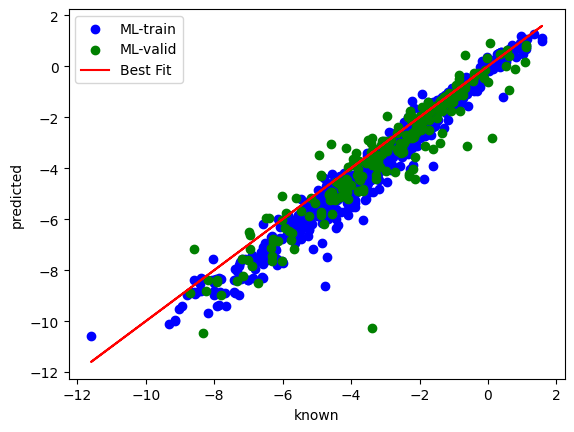

In [12]:
r2_train, r2_test = evaluate_training(X_train, y_train, X_test, y_test, model)

## Predict the target value for a novel molecule

In [13]:
which = 3
prediction = predict_single_value(smiles[which], model, scaler, truth=y[which])

Predicting value for ClCC(Cl)Cl
Prediction: -1.614274263381958, Truth: -1.48


## Save a model

In [14]:
torch.save(model.state_dict(), "saved_model.pt")

## Load a model
- needs two files from the previous model:
  * the MLP_model_params.txt file
  * the saved_model.pt file
- Both should be in the current folder [("/content") on Colab]

In [15]:
new_model = load_model()

In [16]:
prediction = predict_single_value(smiles[which], new_model, scaler, truth=y[which])

Predicting value for ClCC(Cl)Cl
Prediction: -1.614274263381958, Truth: -1.48
